# Playground datasets train on local computer (II)
&emsp;&emsp;本文档训练playgrond第二个数据集two_gauss_dataset，同样是DNN的二分类问题。模型的构建采用前馈网络全连接层。在实际训练中，发现本数据集为以下四个分类问题中最简单表现也最佳的一个。其困难程度与第一个数据集circle_data相仿，因此两者采用相近的参数进行训练：
+ circle data
+ <b>gauss data</b>
+ xor data
+ spiral data
<img src="img/dataset_subplots3.png" height="50%" width="50%">

&emsp;&emsp;本文在训练模型时遭遇到过拟合现象，将在具体训练过程中展现过拟合对模型性能的影响。

## 1.数据预处理
&emsp;&emsp;由数据生成模块`dataset.py`得到的数据标签为1和-1，考虑到在损失函数中我们可能使用交叉熵(cross-entropy)的形式，即输出$\hat{y}$(output或prediction)实际是分类的概率，应当有$\hat{y} \in [0, 1]$，故将标签正则化为1和0。在`dataset.py`文件中新定义`get_samples`函数获取指定生成类型和样本量的样本及标签。
```python
def get_samples(data_type, size, noise):
    raw_data = data_type(size, noise)
    x1 = [r["x"] for r in raw_data]
    x2 = [r["y"] for r in raw_data]
    lab = [r["label"] for r in raw_data]
    data = np.array(list(zip(x1, x2)))
    label = np.clip(np.array(lab), 0.0, 1.0)
    return data, label
```

## 2.定义计算图
&emsp;&emsp;通过先在`playground`上进行试验，仅采用$x_1, \ x_2$两个features也能在小规模模型中获得较快的收敛速度。在优化过程中，使用批量优化(batch optimization，参见_Deep Learning_ 8.1.3节)训练模型非常困难（收敛慢）；转而采用小批量优化方法(mini batch)。定义该模型计算图要素如下：
+ training size: 500
+ noise rate: 0.1(10 in `playground`)
+ hidden layers: 2
+ nodes in each layer: 4
+ activation func: ReLu
+ output activation func: ReLu
+ loss func: MSE
+ batch_size: 50
+ learning_rate: 0.1
+ epochs: 200

In [2]:
#!/usr/bin/python
# coding:utf-8
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from dataset import *
%matplotlib inline
import matplotlib.pyplot as plt


data, label = get_samples(classify_two_gauss_data, 500, 0.1)
# define data in default graph
X = tf.placeholder(dtype=tf.float32, shape=(None, 2), name="input")
Y = tf.placeholder(dtype=tf.float32, shape=None, name="label")

# try two hidden layers with 4 nodes each(3 layers in total)
n_hidden1 = 4
n_hidden2 = 4
n_output = 1
with tf.name_scope("dnn_gauss"):
    hidden1 = fully_connected(X, n_hidden1, tf.nn.relu, scope="hidden1")
    hidden2 = fully_connected(hidden1, n_hidden2, tf.nn.relu, scope="hidden2")
    # only affine mapping, before activation function
    logits = fully_connected(hidden2, n_output, scope="output", activation_fn=None)
with tf.name_scope("loss"):
    pred_y = tf.nn.relu(logits)
    loss = tf.reduce_mean(tf.square(pred_y-Y))
learning_rate = 0.1
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
with tf.name_scope("eval"):
    # 分类标准，pred_y>0.5则分类为1；反之分类为0
    concat_logits = tf.concat([tf.zeros_like(pred_y, tf.float32)+0.5, pred_y], axis=1)
    correct = tf.nn.in_top_k(concat_logits, tf.cast(Y, tf.int32), 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## 3.执行计算和评估
&emsp;&emsp;执行计算部分，每隔100个样本点输出一个预测$\hat{y}$和真实标签$y$

In [3]:
# save 'loss' and 'accuracy' sequences
loss_val = []
acc_val = []
grad_val = []
init = tf.global_variables_initializer()
batch_size = 50
n_epochs = 200
num = data.shape[0]
n_iters = num // batch_size
with tf.Session() as sess:
    init.run()
    print("Model 2: Gauss data")
    for epoch in range(n_epochs):
        for itr in range(n_iters):
            X_batch = data[itr*batch_size:(itr+1)*batch_size, :]
            Y_batch = label[itr*batch_size:(itr+1)*batch_size]
            # 在每4个iter中，用全batch数据计算loss
            if not (itr % 4):
                l = sess.run(loss, feed_dict={X: data, Y: label})
                loss_val.append([epoch*n_iters+itr, l])
            sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        # 每2个epoch中提取gradients并计算accuracy
        if not (epoch % 2):
            acc, grads_and_vars = sess.run([accuracy, optimizer.compute_gradients(loss)], feed_dict={X: data, Y: label})
            grads_norm = np.sum([np.linalg.norm(grad, ord=2)
                                     for grad, _ in grads_and_vars])
        acc_val.append([epoch, acc])
        grad_val.append([epoch, grads_norm])
        if not ((epoch) % 50):
            preds, l = sess.run([pred_y, loss], feed_dict={X: data, Y: label})
            
            print("Prediction:\n{}, \nTrue label:\n{},"
                  " \nLoss:{:.3f}, \nAccuracy:{:.2%}".format(preds[::50], label[::50], l, acc))
loss_val = list(zip(*loss_val))
acc_val = list(zip(*acc_val))
grad_val = list(zip(*grad_val))

Model 2: Gauss data
Prediction:
[[ 1.07514846]
 [ 0.99116242]
 [ 0.73490709]
 [ 1.19938064]
 [ 0.672791  ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]], 
True label:
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.], 
Loss:0.405, 
Accuracy:83.80%
Prediction:
[[ 0.98230064]
 [ 0.97272748]
 [ 0.95325899]
 [ 1.00093591]
 [ 0.94487607]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]], 
True label:
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.], 
Loss:0.471, 
Accuracy:97.80%
Prediction:
[[ 0.96776313]
 [ 0.9665274 ]
 [ 0.95580161]
 [ 0.97169507]
 [ 0.96166641]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]], 
True label:
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.], 
Loss:0.475, 
Accuracy:98.00%
Prediction:
[[ 0.96853423]
 [ 0.9681294 ]
 [ 0.97378159]
 [ 0.96792978]
 [ 0.96810633]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]], 
True label:
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.], 
Loss:0.47

&emsp;&emsp;在前一个模型的训练中，发现训练的loss没有按照期望的逐渐下降；因此在本节中，我们计算并保存每4个iter优化过后的loss，以及每2个epoch后的各参数梯度$L_2$范数之和（如果计算每个iter的梯度耗时太长），每个epoch预测的准确率。

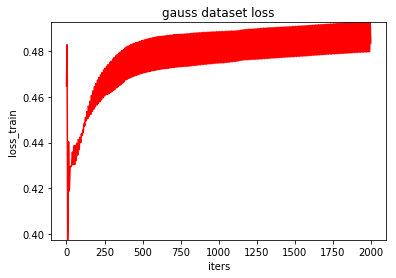

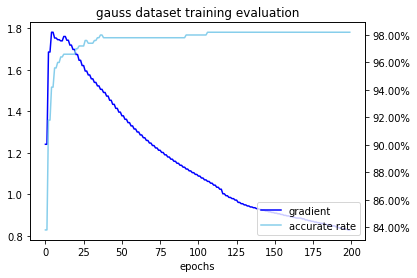

In [4]:

import matplotlib.ticker as ticker
plt.figure(1)
ax1 = plt.gca()
ax1.plot(np.array(loss_val[0]), np.array(loss_val[1]), "-r", label="loss")
pad = 0.01
ax1.set_ylim([np.min(loss_val[1]), np.max(loss_val[1])])
ax1.set_ylabel("loss_train")
ax1.set_xlabel("iters")
plt.title("gauss dataset loss")
plt.show()
plt.figure(2)
ax2 = plt.gca()
ax3 = ax2.twinx()
ax2.plot(np.array(grad_val[0]), np.array(grad_val[1]), 'blue', label="gradient")
ax3.plot(np.array(acc_val[0]), np.array(acc_val[1]) * 100, color="skyblue", label="accurate rate")
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f%%"))
ax2.set_xlabel("epochs")
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles2 + handles3, labels2 + labels3)
plt.title("gauss dataset training evaluation")
plt.show()

&emsp;&emsp;__Surpiring，OVERFITTING comes too soon!__

&emsp;&emsp;由于数据集训练比较简单且数据量少（可见小数据集是极易过拟合的），在少量几个epoch之后训练集上的loss已经达到最低（下图我们放大看前100个iter的loss情况），之后的梯度训练使得loss无法继续下降转而上升，即使在这个过程中预测准确率似乎并没有呈现过拟合的状态，但是我们需要在之后和测试集上的预测准确率进行对比。在训练的末期，梯度仍然保持高峰时值的约50%，表明过拟合可能并非由于局部最小点造成，关于这一问题的探讨，可参考__Deep Learning__中文笔记8.2.2节。


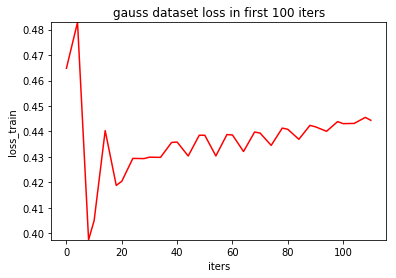

In [5]:
plt.figure(3)
ax1 = plt.gca()
ax1.plot(np.array(loss_val[0])[0:34], np.array(loss_val[1])[0:34], "-r", label="loss")
pad = 0.01
ax1.set_ylim([np.min(loss_val[1][0:34]), np.max(loss_val[1][0:34])])
ax1.set_ylabel("loss_train")
ax1.set_xlabel("iters")
plt.title("gauss dataset loss in first 100 iters")
plt.show()

## 4.测试集上的表现
&emsp;&emsp;由于数据集规模较小，测试集的数据量可以相对较大；测试集生成方式与训练相同，但彼此独立。在`feed_dict`中传入测试集数据，与训练集上的表现进行比较。

In [7]:
test_size_ratio = 0.2
test_data, test_label = get_samples(classify_two_gauss_data, 500 * 0.2, 0.1)
X_test = tf.placeholder(dtype=tf.float32, shape=(None, 2), name="input_test")
Y_test = tf.placeholder(dtype=tf.float32, shape=None, name="label_test")
n_epochs = 150
init = tf.global_variables_initializer()
batch_size = 50
num = data.shape[0]
n_iters = num // batch_size
loss_val_train = []
loss_val_test = []
acc_val_train = []
acc_val_test = []
grad_val = []
with tf.Session() as sess2:
    init.run()
    print("Model 2: Gauss data with testing data")
    for epoch in range(n_epochs):
        for itr in range(n_iters):
            X_batch = data[itr*batch_size:(itr+1)*batch_size, :]
            Y_batch = label[itr*batch_size:(itr+1)*batch_size]
            # 在每4个iter，用全batch数据计算loss
            if not (itr % 4):
                l_train = sess2.run(loss, feed_dict={X: data, Y: label})
                l_test = sess2.run(loss, feed_dict={X: test_data, Y: test_label})
                loss_val_train.append([epoch*n_iters+itr, l_train])
                loss_val_test.append([epoch*n_iters+itr, l_test])
                sess2.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        # 每2个epoch中提取gradients并计算accuracy,accuracy分别在两个数据及上计算
        if not (epoch % 2):
            acc_train, grads_and_vars = sess2.run([accuracy, optimizer.compute_gradients(loss)], feed_dict={X: data, Y: label})
            acc_test = sess2.run(accuracy, feed_dict={X: test_data, Y: test_label})
            grads_norm = np.sum([np.linalg.norm(grad, ord=2)
                                         for grad, _ in grads_and_vars])
            acc_val_train.append([epoch, acc_train])
            acc_val_test.append([epoch, acc_test])
            grad_val.append([epoch, grads_norm])
        if not (epoch % 50):
            preds, l = sess2.run([pred_y, loss], feed_dict={X: data, Y: label})
            print("Prediction:\n{}, \nTrue label:\n{},"
                  " \nLoss:{:.3f}, \nAccuracy:{:.2%}".format(preds[::50], label[::50], l, acc_train))

loss_val_train = list(zip(*loss_val_train))
loss_val_test = list(zip(*loss_val_test))
acc_val_train = list(zip(*acc_val_train))
acc_val_test = list(zip(*acc_val_test))
grad_val = list(zip(*grad_val))

Model 2: Gauss data with testing data
Prediction:
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.03262241]
 [ 0.02239644]
 [ 0.0212319 ]
 [ 0.00868692]
 [ 0.03424544]], 
True label:
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.], 
Loss:0.485, 
Accuracy:50.00%
Prediction:
[[ 1.03804886]
 [ 1.01671779]
 [ 0.99031299]
 [ 1.06808519]
 [ 0.96418494]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.10647988]
 [ 0.        ]], 
True label:
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.], 
Loss:0.466, 
Accuracy:96.80%
Prediction:
[[ 1.00340736]
 [ 0.99966925]
 [ 0.99380887]
 [ 1.00887966]
 [ 0.99029022]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]], 
True label:
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.], 
Loss:0.480, 
Accuracy:96.80%


&emsp;&emsp;画出训练集和测试集上的loss对比；accuracy对比，以及训练集上的梯度变化。

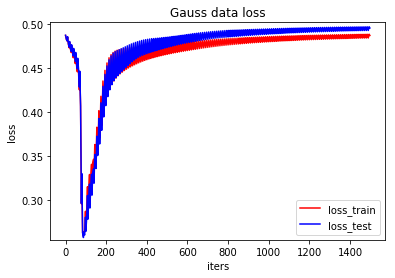

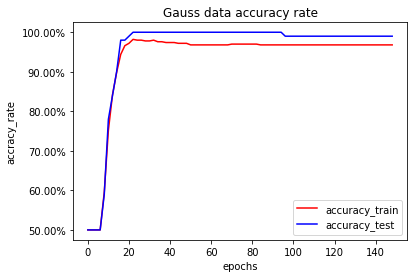

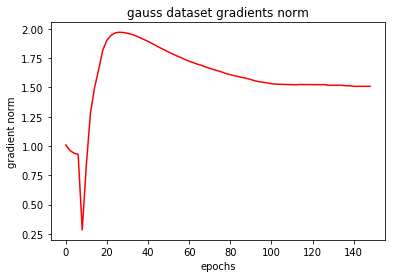

In [8]:

import matplotlib.ticker as ticker
# loss plot
plt.figure(1)
plt.plot(np.array(loss_val_train[0]), np.array(loss_val_train[1]), "-r", label="loss_train")
plt.plot(np.array(loss_val_test[0]), np.array(loss_val_test[1]), color="blue", label="loss_test")
pad = 0.01

plt.ylim([np.min(loss_val_train[1]+loss_val_test[1])*(1-pad), 
          np.max(loss_val_train[1]+loss_val_test[1])*(1+pad)])
plt.title("Gauss data loss")
plt.xlabel("iters")
plt.ylabel("loss")
plt.legend()
# accuracy plot
plt.figure(2)
plt.plot(np.array(acc_val_train[0]), np.array(acc_val_train[1]) * 100, "-r", label="accuracy_train")
plt.plot(np.array(acc_val_test[0]), np.array(acc_val_test[1]) * 100, color="blue", label="accuracy_test")
plt.title("Gauss data accuracy rate")
plt.xlabel("epochs")
plt.ylabel("accracy_rate")
ax2 = plt.gca()
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f%%"))
plt.legend()
# gradient plot
plt.figure(3)
plt.plot(np.array(grad_val[0]), np.array(grad_val[1]), "-r", label="gradients_norm")
plt.xlabel("epochs")
plt.ylabel("gradient norm")
plt.title("gauss dataset gradients norm")
plt.show()